In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/ge"

In [12]:
models = [
    "CADD.RawScore",
    #"phyloP",
    #"phastCons",
    "phyloP-Zoonomia",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    "Enformer.LogisticRegression",
    #"LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,tss_dist,match_group,CADD,phyloP-241-mammals,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,14677,G,A,0.992227,0.055024,True,ENSG00000186092,50740,0,-0.370660,-1.902,NaN,NaN,NaN,NaN,NaN
1,1,54490,G,A,1.000000,0.159938,True,ENSG00000186092,10927,1,0.201295,-0.029,-0.322472,-0.301124,-0.381684,-0.285615,-0.282465
2,1,63671,G,A,0.998592,0.156388,True,ENSG00000186092,1746,2,-0.344458,-0.253,-0.329238,-0.120538,-0.500216,-0.315284,-0.447925
3,1,63697,T,C,0.977568,0.195652,True,ENSG00000186092,1720,3,-1.180623,-2.212,NaN,NaN,NaN,NaN,NaN
4,1,108826,G,C,1.000000,0.040023,True,ENSG00000186092,43407,4,-0.018075,2.419,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,X,155672303,G,A,0.962191,0.436727,True,ENSG00000185973,46793,10785,-0.082362,-0.073,NaN,NaN,NaN,NaN,NaN
21572,X,155699751,C,T,0.009055,0.272081,False,ENSG00000185973,19345,10650,-0.471871,3.064,NaN,NaN,NaN,NaN,NaN
21573,X,155717737,C,T,0.008111,0.193577,False,ENSG00000185973,1359,10780,-0.065500,-0.316,NaN,NaN,NaN,NaN,NaN
21574,X,155768650,G,T,0.991784,0.455970,True,ENSG00000168939,838,10786,-1.179355,-2.759,NaN,NaN,NaN,NaN,NaN


In [13]:
"""
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()
""";

In [14]:
V.dropna(
    subset=models,
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,tss_dist,match_group,CADD,phyloP-241-mammals,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
1,1,54490,G,A,1.000000,0.159938,True,ENSG00000186092,10927,1,0.201295,-0.029,-0.322472,-0.301124,-0.381684,-0.285615,-0.282465
2,1,63671,G,A,0.998592,0.156388,True,ENSG00000186092,1746,2,-0.344458,-0.253,-0.329238,-0.120538,-0.500216,-0.315284,-0.447925
5,1,286747,A,G,1.000000,0.151295,True,ENSG00000284733,164929,5,-0.241201,-0.454,-0.287834,-0.187136,-0.334257,-0.219478,-0.260316
7,1,917584,T,G,0.996919,0.199664,True,ENSG00000187634,6337,7,-1.103527,-2.807,-0.861463,-0.770140,-0.925562,-0.766922,-0.835719
8,1,936972,G,C,0.993869,0.322299,True,ENSG00000187634,2301,8,0.073415,1.420,-0.748306,-0.920735,-0.909909,-0.773233,-0.796997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,22,50656498,C,T,0.932085,0.207976,True,ENSG00000251322,17915,7106,-1.300250,-0.685,-0.849293,-0.609465,-0.993886,-0.792297,-0.752442
21048,22,50665389,G,A,0.006481,0.030702,False,ENSG00000251322,9024,6703,0.072892,1.821,-0.377379,-0.463274,-0.439497,-0.468812,-0.333826
21049,22,50733265,G,A,0.971032,0.302632,True,ENSG00000251322,3693,7107,0.542960,0.043,-0.671090,-0.829912,-0.422867,-0.689066,-0.698482
21050,22,50783672,G,T,0.964513,0.080189,True,ENSG00000079974,5,7108,-0.699263,-0.682,-0.865115,-0.709733,-0.999996,-0.903823,-0.839272


In [15]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     9674
False    9674
Name: count, dtype: int64

## Testing

In [16]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 7/7 [00:00<00:00, 104.51it/s]


,Model,AUROC
4,Enformer.LogisticRegression,0.763371
3,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.750663
6,multiz100way/89/512/256/True/defined.phastCons...,0.722091
5,multiz100way/89/256/128/True/defined.phastCons...,0.717328
2,multiz100way/89/128/64/True/defined.phastCons....,0.709544
0,CADD,0.555509
1,phyloP-241-mammals,0.516927


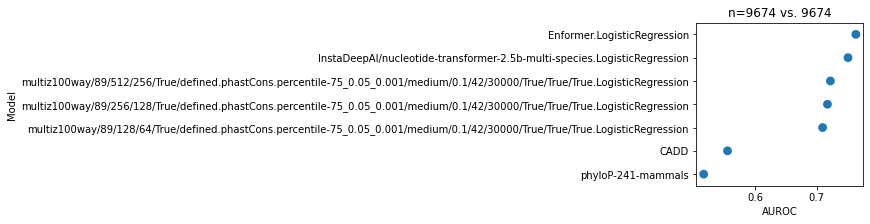

In [17]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);